# Transformace dat

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('cp.csv')
df.head()

Hotel_Address       City  \
0  7 Pepys Street City of London London EC3N 4AF ...     London   
1  10 Godliman Street City of London London EC4V ...     London   
2  24 Ludgate Hill City of London London EC4M 7DR...     London   
3  Via Lucio Giunio Columella 36 Distretto Viale ...      Milan   
4           Caspe 103 Eixample 08013 Barcelona Spain  Barcelona   

                                  merged_review_text  Reviewer_Score  
0   Tv was a bit small and sound couldn t be turn...             9.2  
1   Breakfast to be included in the price Locatio...             8.3  
2   Mattress was a little hard but clean  Excelle...             9.6  
3   Everything was great  Location room bathroom ...            10.0  
4   We had a nicer room assigned but the bed had ...             8.8

### Vyzkoušení Google API

Let's decide what will suit us better - spacy or g.api?

In [3]:
import spacy
from google.cloud import language_v1
from google.oauth2 import service_account
creds = service_account.Credentials.from_service_account_file('./credentials.json')
client = language_v1.LanguageServiceClient(credentials=creds)
language = "en"
type_ = language_v1.Document.Type.PLAIN_TEXT
encoding_type = language_v1.EncodingType.UTF8

https://googleapis.dev/python/language/latest/usage.html According to the documentation, the Google language API does not have the desired functionality, so I will continue using spaCy

## Práce se spaCy

In [4]:
nlp = spacy.load('en_core_web_md') #loading the language model

For our desired outcome we need the word type classification feature, which works as following:

In [7]:
doc = nlp("This is a sentence.")

pos = pd.DataFrame()

for token in doc:
    pos.loc[token, "pos"] = token.pos
    pos.loc[token, "pos_"] = token.pos_
    pos.loc[token, "explained"] = spacy.explain(token.pos_)

pos

pos   pos_    explained
This      90.0    DET   determiner
is        87.0    AUX    auxiliary
a         90.0    DET   determiner
sentence  92.0   NOUN         noun
.         97.0  PUNCT  punctuation

So the idea is
- Get the values for every review
- encode the counts into a new dataframe with value counts for every single review
- recalculate the review counts into proportions, which I believe makes more sense and will make the space less sparse, which could later help the clustering algorithm

- Get table for each review
- Get counts from each table
- Get counts into appropriate columns
- Calculate ratio
- Keep sum

In [5]:
doc = nlp(df['merged_review_text'][42])
pos = pd.DataFrame()
for token in doc:
    pos.loc[token,'pos_'] = token.pos_
    
pos

pos_
              SPACE
We             PRON
found          VERB
it             PRON
difficult       ADJ
initially       ADV
to             PART
manage         VERB
the             DET
room           NOUN
temperature    NOUN
owing          VERB
to              ADP
two             NUM
sets           NOUN
of              ADP
controls       NOUN
for             ADP
air            NOUN
conditioning   NOUN
and           CCONJ
no              DET
opening        NOUN
windows        NOUN
              SPACE
Very            ADV
pleasant        ADJ
friendly        ADJ
helpful         ADJ
staff          NOUN
Within          ADP
easy            ADJ
access         NOUN
of              ADP
historic        ADJ
parts          NOUN
of              ADP
Greenwich     PROPN
Good            ADJ
food           NOUN
in              ADP
hotel          NOUN
restaurant     NOUN
and           CCONJ
plenty         NOUN
of              ADP
nearby          ADJ
alternatives   NOUN
too             ADV

#### This function is able to do what is outlined above

In [6]:
type_list = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON',
             'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X','SPACE']
#now to figure out how to get the counts row
def vectorizer(data_column):
    
    '''This very suboptimal function takes a data column and creates a new dataframe based on that column. It creates
        a row containing the word type counts for each string (review) and concatenates the row to the new vectorized
        dataframe. Eventually the function divides the values by the total number of words to get proportions.
        
        The worst iterative function in the history of iterative functions, maybe ever.
        '''
    
    vectorized_df = pd.DataFrame(columns=type_list)
    for row in data_column.values:
        doc = nlp(row)
        pos = pd.DataFrame()
        for token in doc:
            pos.loc[token,'pos_'] = token.pos_
        #have the pos table    
        vector = pd.DataFrame(pos['pos_'].value_counts()).reset_index()
        vector = vector.transpose()
        new_header = vector.iloc[0]
        vector = vector[1:]
        vector.columns = new_header #there's definitely a better, faster way but whatever
        vectorized_df = pd.concat([vectorized_df,vector]) #or the following, takes much more time though
        #vectorized_df = vectorized_df.append(vector)
    vectorized_df = vectorized_df.drop('SPACE', axis=1)
    vectorized_df.fillna(0, inplace=True)
    
    vectorized_df['sum'] = vectorized_df.sum(axis=1)
    vectorized_df.loc[:,"ADJ":"X"] = vectorized_df.loc[:,"ADJ":"X"].div(vectorized_df["sum"], axis=0)
    #vectorized_df = vectorized_df.drop('sum', axis=1) #for the sake of the clustering I decided NOT to drop the sum and include
    #it in the resulting dataset since by making proportions I lose information about word count

    
    return vectorized_df

### Test function

In [7]:
please = vectorizer(df['merged_review_text'][:5])
please

ADJ       ADP       ADV       AUX  CONJ     CCONJ       DET  INTJ  \
pos_  0.172414  0.051724  0.120690  0.155172   0.0  0.068966  0.068966   0.0   
pos_  0.214286  0.071429  0.071429  0.071429   0.0  0.000000  0.071429   0.0   
pos_  0.333333  0.066667  0.000000  0.066667   0.0  0.133333  0.133333   0.0   
pos_  0.222222  0.000000  0.111111  0.111111   0.0  0.000000  0.000000   0.0   
pos_  0.132075  0.132075  0.037736  0.075472   0.0  0.047170  0.122642   0.0   

          NOUN  NUM      PART      PRON     PROPN  PUNCT     SCONJ  SYM  \
pos_  0.120690  0.0  0.017241  0.051724  0.086207    0.0  0.000000  0.0   
pos_  0.357143  0.0  0.071429  0.000000  0.000000    0.0  0.000000  0.0   
pos_  0.200000  0.0  0.000000  0.000000  0.066667    0.0  0.000000  0.0   
pos_  0.444444  0.0  0.000000  0.111111  0.000000    0.0  0.000000  0.0   
pos_  0.207547  0.0  0.009434  0.047170  0.066038    0.0  0.009434  0.0   

          VERB    X  sum  
pos_  0.086207  0.0   58  
pos_  0.071429  0.0   14  
pos_  0.000000  0.0   15  
pos_  0.000000  0.0    9  
pos_  0.113208  0.0  106

Now I need a df with ALL possible types as columns and match the values from the vectorizer function output

## Transform data

In [8]:
#ah it works, let's give it the big one then

vectorized_df = vectorizer(df['merged_review_text'])
vectorized_df.head()

ADJ       ADP       ADV       AUX  CONJ     CCONJ       DET  INTJ  \
pos_  0.172414  0.051724  0.120690  0.155172   0.0  0.068966  0.068966   0.0   
pos_  0.214286  0.071429  0.071429  0.071429   0.0  0.000000  0.071429   0.0   
pos_  0.333333  0.066667  0.000000  0.066667   0.0  0.133333  0.133333   0.0   
pos_  0.222222  0.000000  0.111111  0.111111   0.0  0.000000  0.000000   0.0   
pos_  0.132075  0.132075  0.037736  0.075472   0.0  0.047170  0.122642   0.0   

          NOUN  NUM      PART      PRON     PROPN  PUNCT     SCONJ  SYM  \
pos_  0.120690  0.0  0.017241  0.051724  0.086207    0.0  0.000000  0.0   
pos_  0.357143  0.0  0.071429  0.000000  0.000000    0.0  0.000000  0.0   
pos_  0.200000  0.0  0.000000  0.000000  0.066667    0.0  0.000000  0.0   
pos_  0.444444  0.0  0.000000  0.111111  0.000000    0.0  0.000000  0.0   
pos_  0.207547  0.0  0.009434  0.047170  0.066038    0.0  0.009434  0.0   

          VERB    X  sum  
pos_  0.086207  0.0   58  
pos_  0.071429  0.0   14  
pos_  0.000000  0.0   15  
pos_  0.000000  0.0    9  
pos_  0.113208  0.0  106

In [9]:
len(vectorized_df)

10000

### Save csv for safety purposes, function takes a long time

In [10]:
vectorized_df.to_csv('cp2_v2.csv',index=False)

### Remove NaNs

In [11]:
vectorized_df.isnull().sum() #there might be some empty strings

ADJ      3
ADP      3
ADV      3
AUX      3
CONJ     3
CCONJ    3
DET      3
INTJ     3
NOUN     3
NUM      3
PART     3
PRON     3
PROPN    3
PUNCT    3
SCONJ    3
SYM      3
VERB     3
X        3
sum      0
dtype: int64

In [12]:
vectorized_df_clear = vectorized_df.dropna()
len(vectorized_df_clear) #all clear now

9997

# Clustering

The worst part is behind us, let's create some clusters now

*btw. from Pandas documentation:*

*Iteratively appending rows to a DataFrame can be more computationally intensive than a single concatenate. A better solution is to append those rows to a list and then concatenate the list with the original DataFrame all at once.*

*Well im not sure how to this task using a list since there are unmatched columns, so whatever*

*The append solution takes actually much longer than the concat solution, damn*

In [13]:
#let's make some clustering... kmeans or dbscan? Let's compare them both
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

## Decide optimal number of clusters

### Inertia for elbow

In [14]:
def model_inertias(features, max_cl=21):
    try_cl = range(1,max_cl)
    inertias = []
    
    for i in try_cl:
        kmeans = KMeans(init='random', n_clusters = i, n_init = 10, max_iter = 300, random_state = 42)
        kmeans.fit(features)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    plt.plot(range(1,max_cl), inertias)
    plt.xticks(range(1,max_cl))
    plt.title('Elbow method for KMeans')
    plt.show()

### Silhouette score

In [15]:
def model_sscore(features, max_cl = 21):
    scores = []
    try_cl = range(2,max_cl)
    
    for i in try_cl:
        kmeans = KMeans(init='random', n_clusters = i, n_init = 10, max_iter = 300, random_state = 42)
        kmeans.fit(features)
        sil = silhouette_score(features, kmeans.labels_)
        scores.append(sil)
        
    plt.plot(range(2,max_cl), scores)
    plt.xticks(range(2,max_cl))
    plt.title('Silhouette scores for KMeans')
    plt.show()

### Pipeline & first look

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 2, random_state = 42))
]) #I need to keep this fit for the purpose of the final prediction

In [17]:
no_of_clusters_df = vectorized_df_clear.copy()
no_of_clusters_df.head()

ADJ       ADP       ADV       AUX  CONJ     CCONJ       DET  INTJ  \
pos_  0.172414  0.051724  0.120690  0.155172   0.0  0.068966  0.068966   0.0   
pos_  0.214286  0.071429  0.071429  0.071429   0.0  0.000000  0.071429   0.0   
pos_  0.333333  0.066667  0.000000  0.066667   0.0  0.133333  0.133333   0.0   
pos_  0.222222  0.000000  0.111111  0.111111   0.0  0.000000  0.000000   0.0   
pos_  0.132075  0.132075  0.037736  0.075472   0.0  0.047170  0.122642   0.0   

          NOUN  NUM      PART      PRON     PROPN  PUNCT     SCONJ  SYM  \
pos_  0.120690  0.0  0.017241  0.051724  0.086207    0.0  0.000000  0.0   
pos_  0.357143  0.0  0.071429  0.000000  0.000000    0.0  0.000000  0.0   
pos_  0.200000  0.0  0.000000  0.000000  0.066667    0.0  0.000000  0.0   
pos_  0.444444  0.0  0.000000  0.111111  0.000000    0.0  0.000000  0.0   
pos_  0.207547  0.0  0.009434  0.047170  0.066038    0.0  0.009434  0.0   

          VERB    X  sum  
pos_  0.086207  0.0   58  
pos_  0.071429  0.0   14  
pos_  0.000000  0.0   15  
pos_  0.000000  0.0    9  
pos_  0.113208  0.0  106

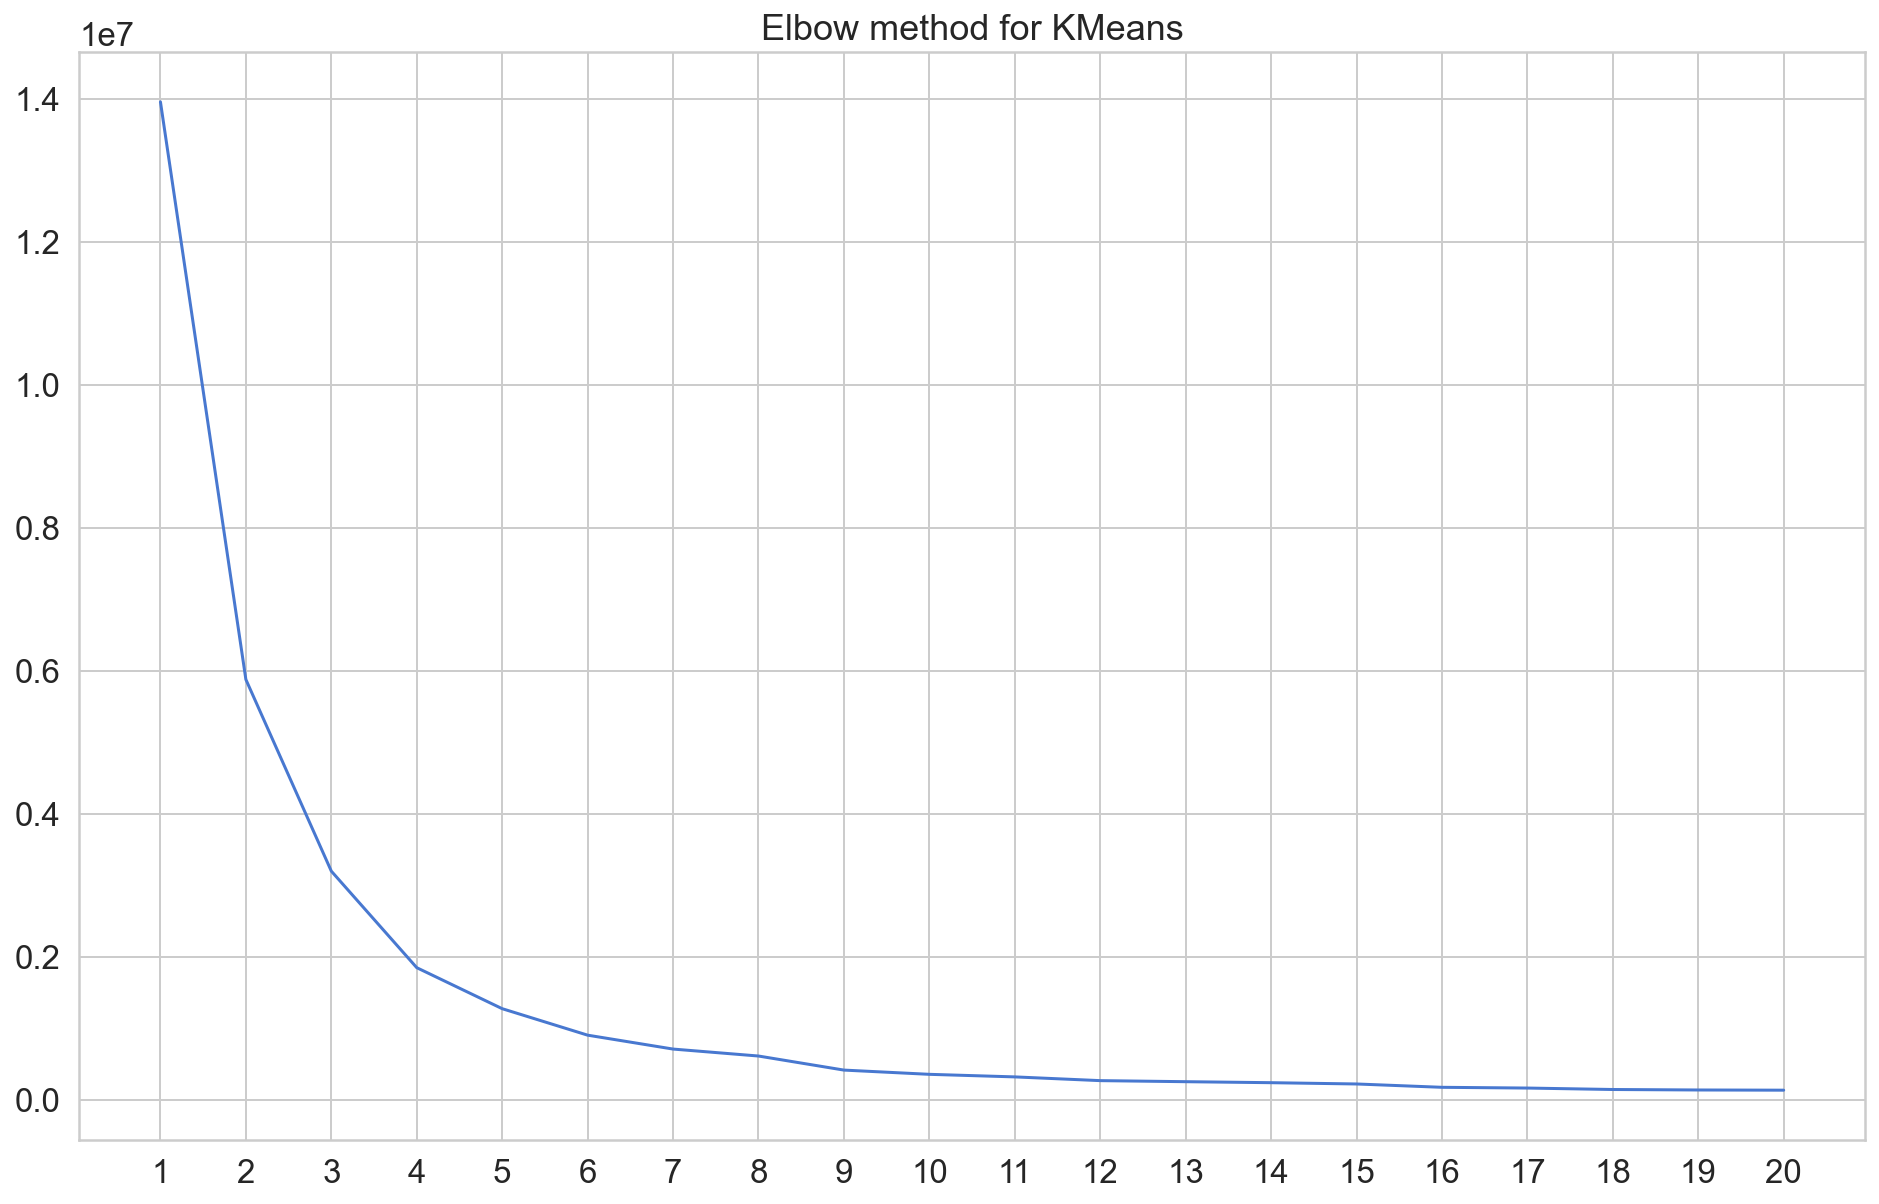

In [18]:
model_inertias(no_of_clusters_df)

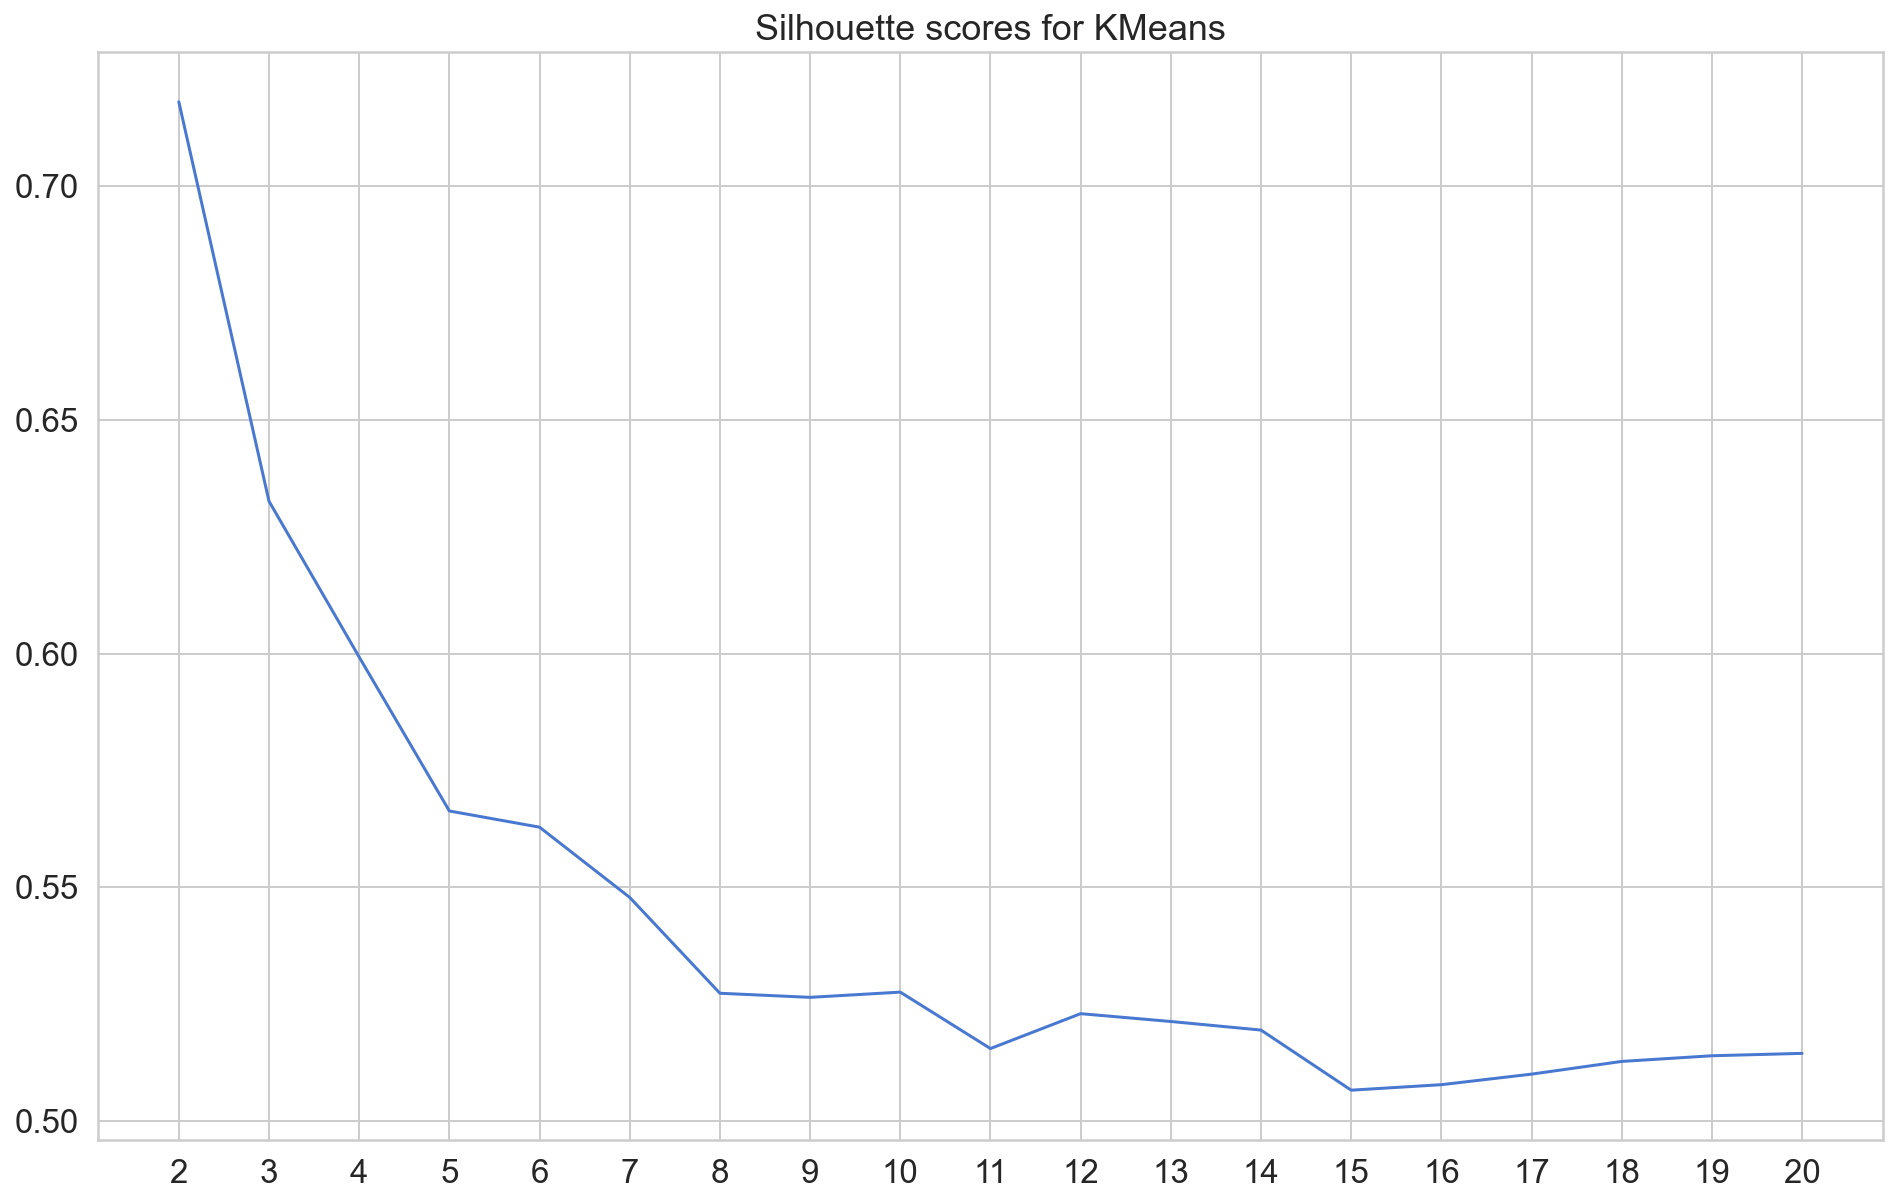

In [19]:
model_sscore(no_of_clusters_df)

### Apply PCA and standardize

In [20]:
no_of_clusters_df = preprocessing_pipeline.fit_transform(no_of_clusters_df) #after this I will keep this a ndarray

In [21]:
no_of_clusters_df #2D data now

array([[ 0.45273622,  1.90106799],
       [-0.59768728, -0.18564981],
       [-2.02528111,  0.32762406],
       ...,
       [-0.40080101, -0.3717841 ],
       [-0.58548931,  0.41247239],
       [ 0.54749231, -0.52103924]])

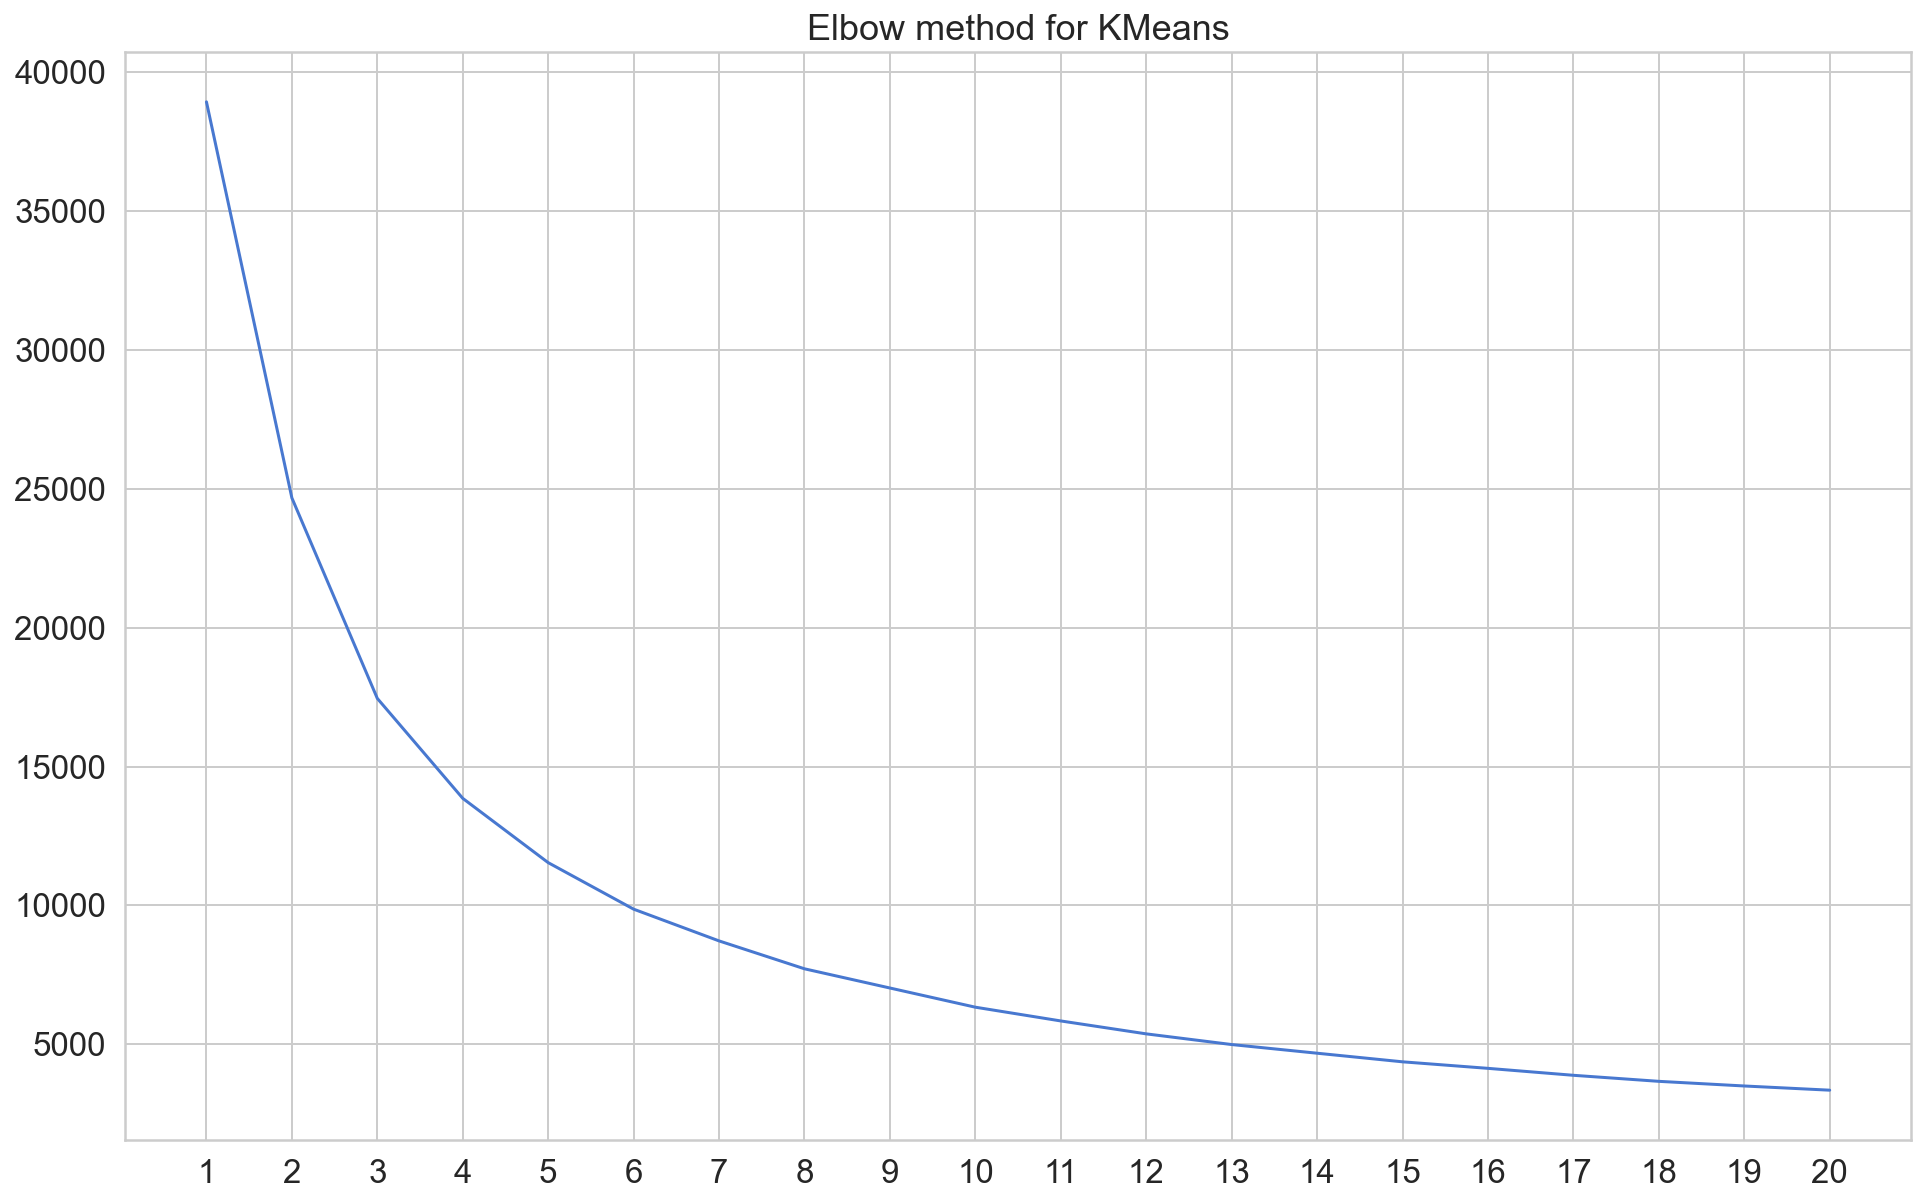

In [22]:
model_inertias(no_of_clusters_df) 

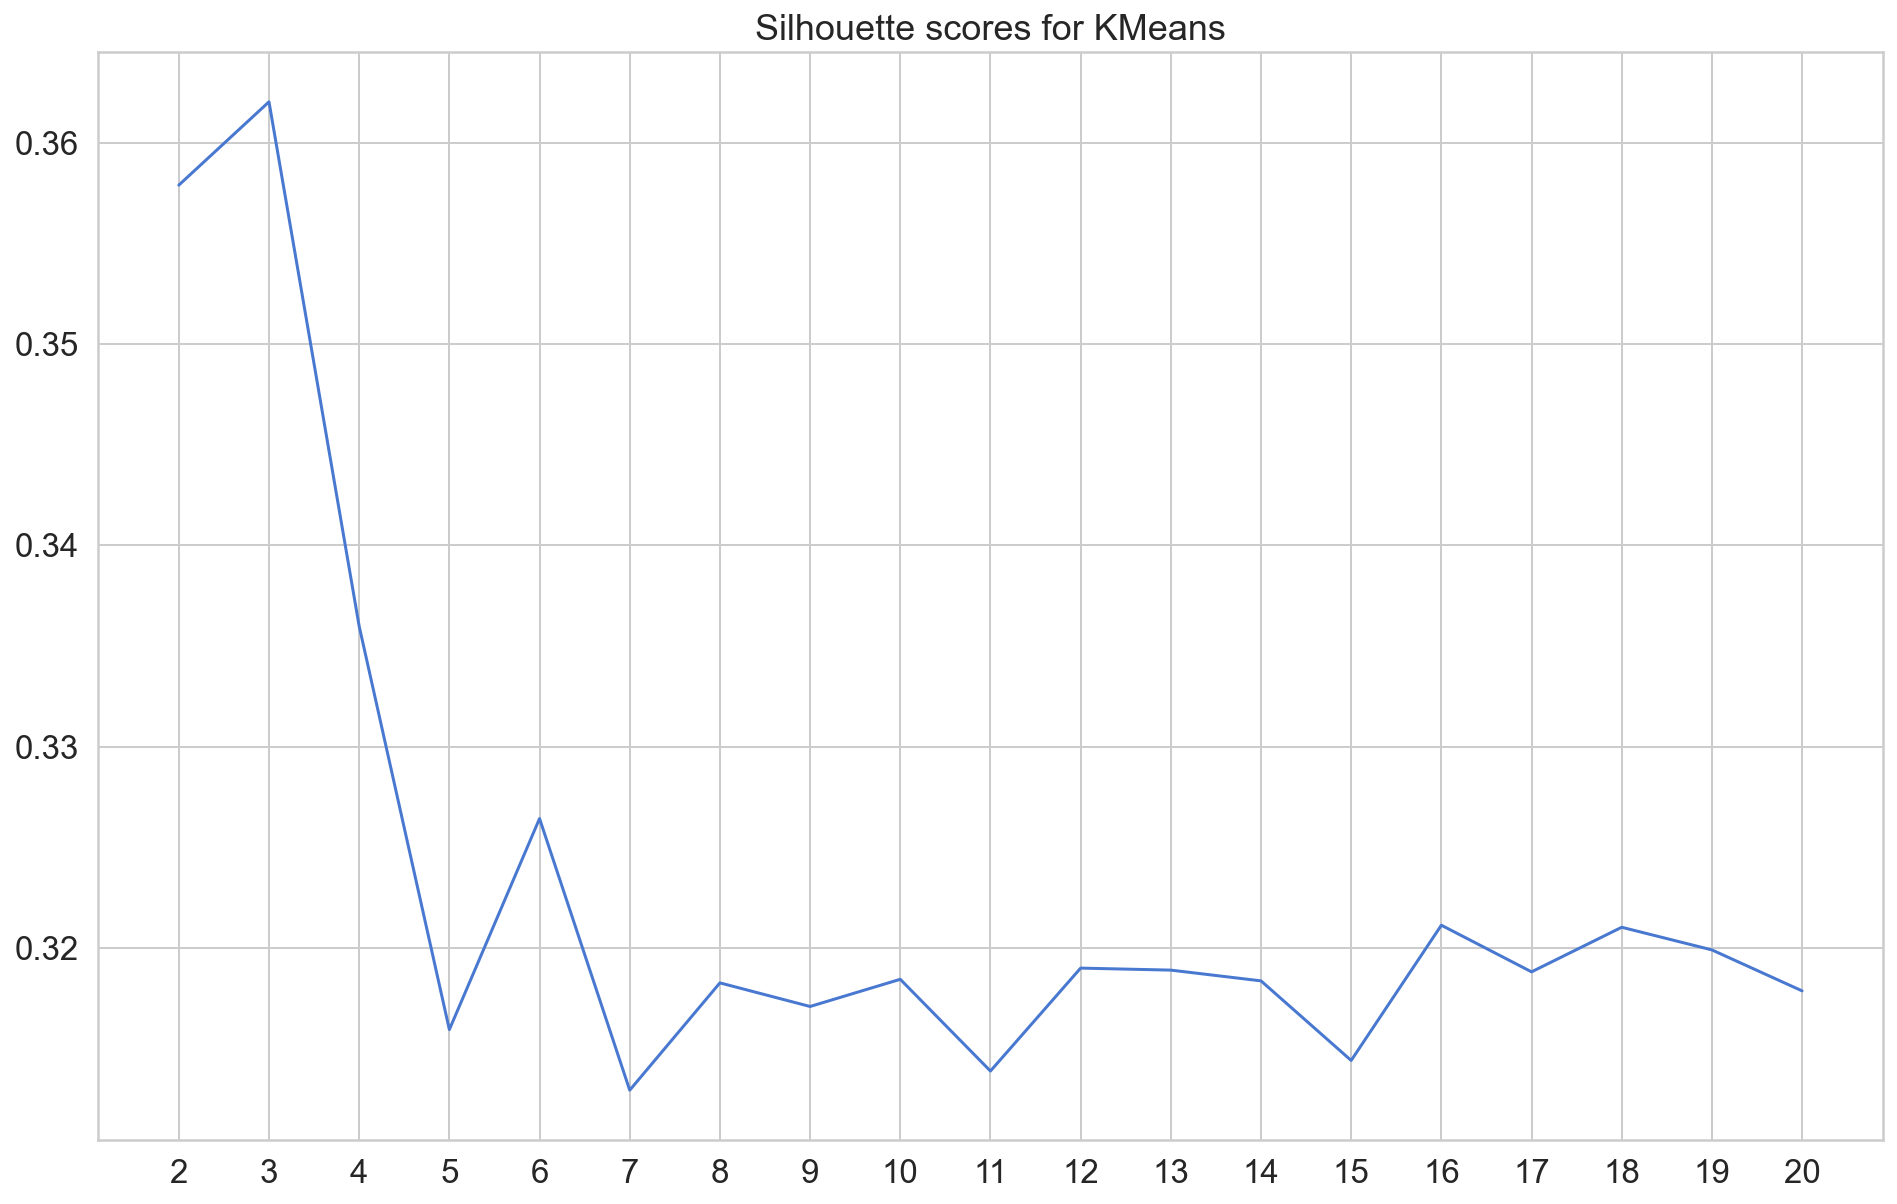

In [23]:
model_sscore(no_of_clusters_df)

## Scatter and finalizing number of clusters

So the number of clusters, if we use KMeans, is 6, even though this is not great. Let's see about DBSCAN. Let's have a looksie at the scatterplot.

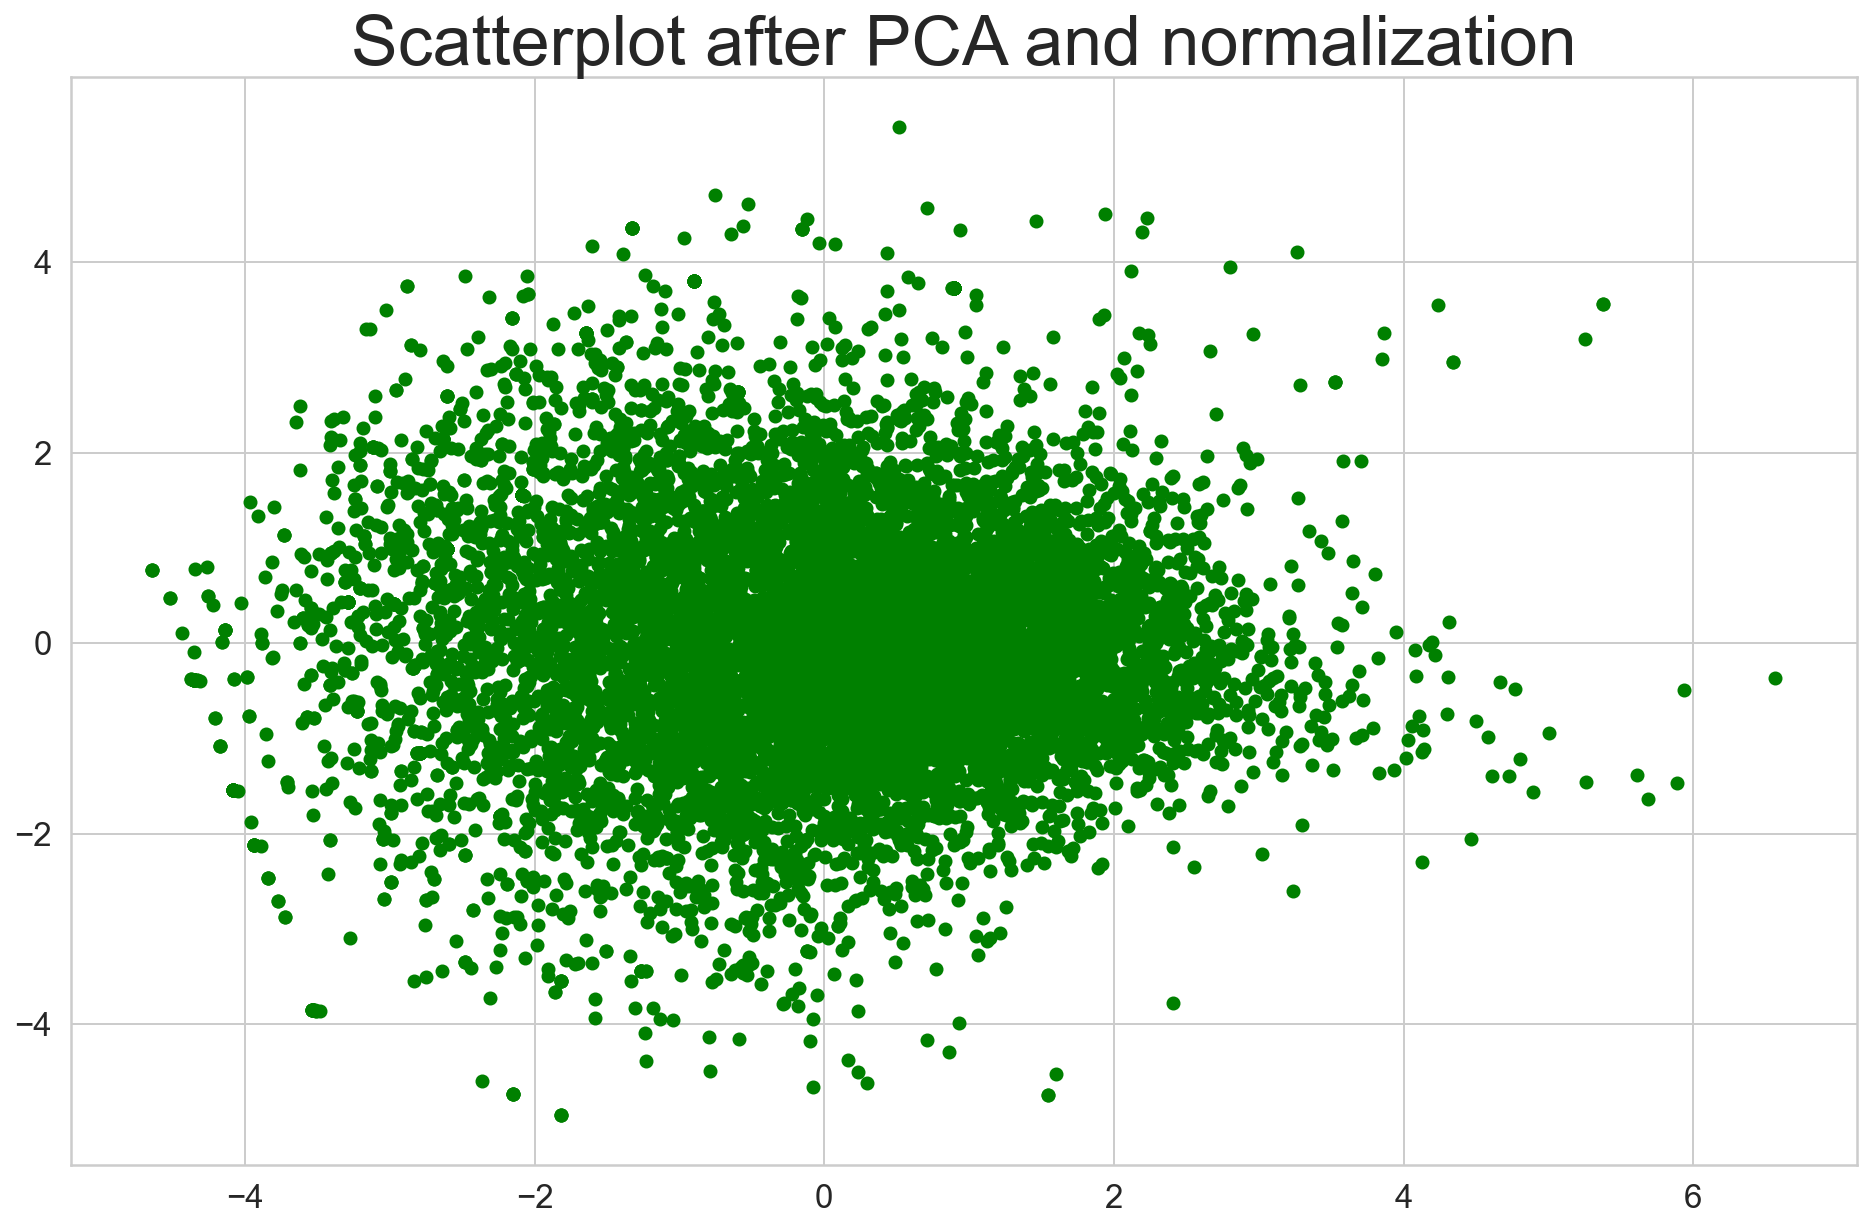

In [29]:
no_of_clusters_df = pd.DataFrame(no_of_clusters_df)
plt.scatter(x=no_of_clusters_df[0],y=no_of_clusters_df[1], c = 'green')
plt.title('Scatterplot after PCA and normalization', fontsize = 35)
plt.show()

### Data does not seem to be fit for clustering.

So performing clustering on this is OBVIOUSLY not a good idea. Whatever, for the sake of this miniproject I'll pretend there are some beautiful clusters and I"ll just continue with KMeans, since DBScan or any other density based algorithm would be inefficient.

### Removing NaNs in original dataset

In [30]:
#oh and let's get rid of the nulls in the original unvectorized dataset

df_pos = vectorized_df.copy() 
df_pos.set_index(pd.Index(list(range(10000))),inplace=True)
indices_lookup = df_pos[df_pos['ADJ'].isnull()].index.tolist()
indices_lookup

[6306, 7140, 8836]

In [32]:
df_pos = df_pos.drop(df_pos.index[indices_lookup])
len(df_pos)

9997

In [33]:
df_orig = df.copy()
df_orig = df_orig.drop(df_orig.index[indices_lookup])
len(df_orig)

9997

In [36]:
df_pos.head()

ADJ       ADP       ADV       AUX  CONJ     CCONJ       DET  INTJ  \
0  0.172414  0.051724  0.120690  0.155172   0.0  0.068966  0.068966   0.0   
1  0.214286  0.071429  0.071429  0.071429   0.0  0.000000  0.071429   0.0   
2  0.333333  0.066667  0.000000  0.066667   0.0  0.133333  0.133333   0.0   
3  0.222222  0.000000  0.111111  0.111111   0.0  0.000000  0.000000   0.0   
4  0.132075  0.132075  0.037736  0.075472   0.0  0.047170  0.122642   0.0   

       NOUN  NUM      PART      PRON     PROPN  PUNCT     SCONJ  SYM  \
0  0.120690  0.0  0.017241  0.051724  0.086207    0.0  0.000000  0.0   
1  0.357143  0.0  0.071429  0.000000  0.000000    0.0  0.000000  0.0   
2  0.200000  0.0  0.000000  0.000000  0.066667    0.0  0.000000  0.0   
3  0.444444  0.0  0.000000  0.111111  0.000000    0.0  0.000000  0.0   
4  0.207547  0.0  0.009434  0.047170  0.066038    0.0  0.009434  0.0   

       VERB    X  sum  
0  0.086207  0.0   58  
1  0.071429  0.0   14  
2  0.000000  0.0   15  
3  0.000000  0.0    9  
4  0.113208  0.0  106

### REFERENCE DFRAMES
- df_orig (original data)
- df_pos (df with POS tags)
- no_of_clusters_df (df_pos after PCA transformation)

In [38]:
#let's get back to the clustering
kmeans = KMeans(n_clusters=4) 
kmeans.fit(no_of_clusters_df)

KMeans(n_clusters=4)

In [39]:
df_orig['CLUSTER'] = pd.Series(kmeans.predict(no_of_clusters_df),dtype='int32') #adding clusters to original dataset
df_orig.head()

Hotel_Address       City  \
0  7 Pepys Street City of London London EC3N 4AF ...     London   
1  10 Godliman Street City of London London EC4V ...     London   
2  24 Ludgate Hill City of London London EC4M 7DR...     London   
3  Via Lucio Giunio Columella 36 Distretto Viale ...      Milan   
4           Caspe 103 Eixample 08013 Barcelona Spain  Barcelona   

                                  merged_review_text  Reviewer_Score  CLUSTER  
0   Tv was a bit small and sound couldn t be turn...             9.2      2.0  
1   Breakfast to be included in the price Locatio...             8.3      3.0  
2   Mattress was a little hard but clean  Excelle...             9.6      1.0  
3   Everything was great  Location room bathroom ...            10.0      1.0  
4   We had a nicer room assigned but the bed had ...             8.8      0.0

In [40]:
df_orig['CLUSTER'].value_counts()

0.0    3548
3.0    2703
2.0    2268
1.0    1475
Name: CLUSTER, dtype: int64

In [41]:
df_orig.to_csv('df_clustered.csv', index=False)

In [42]:
no_of_clusters_df['CLUSTER'] = pd.Series(kmeans.predict(no_of_clusters_df),dtype='int32')

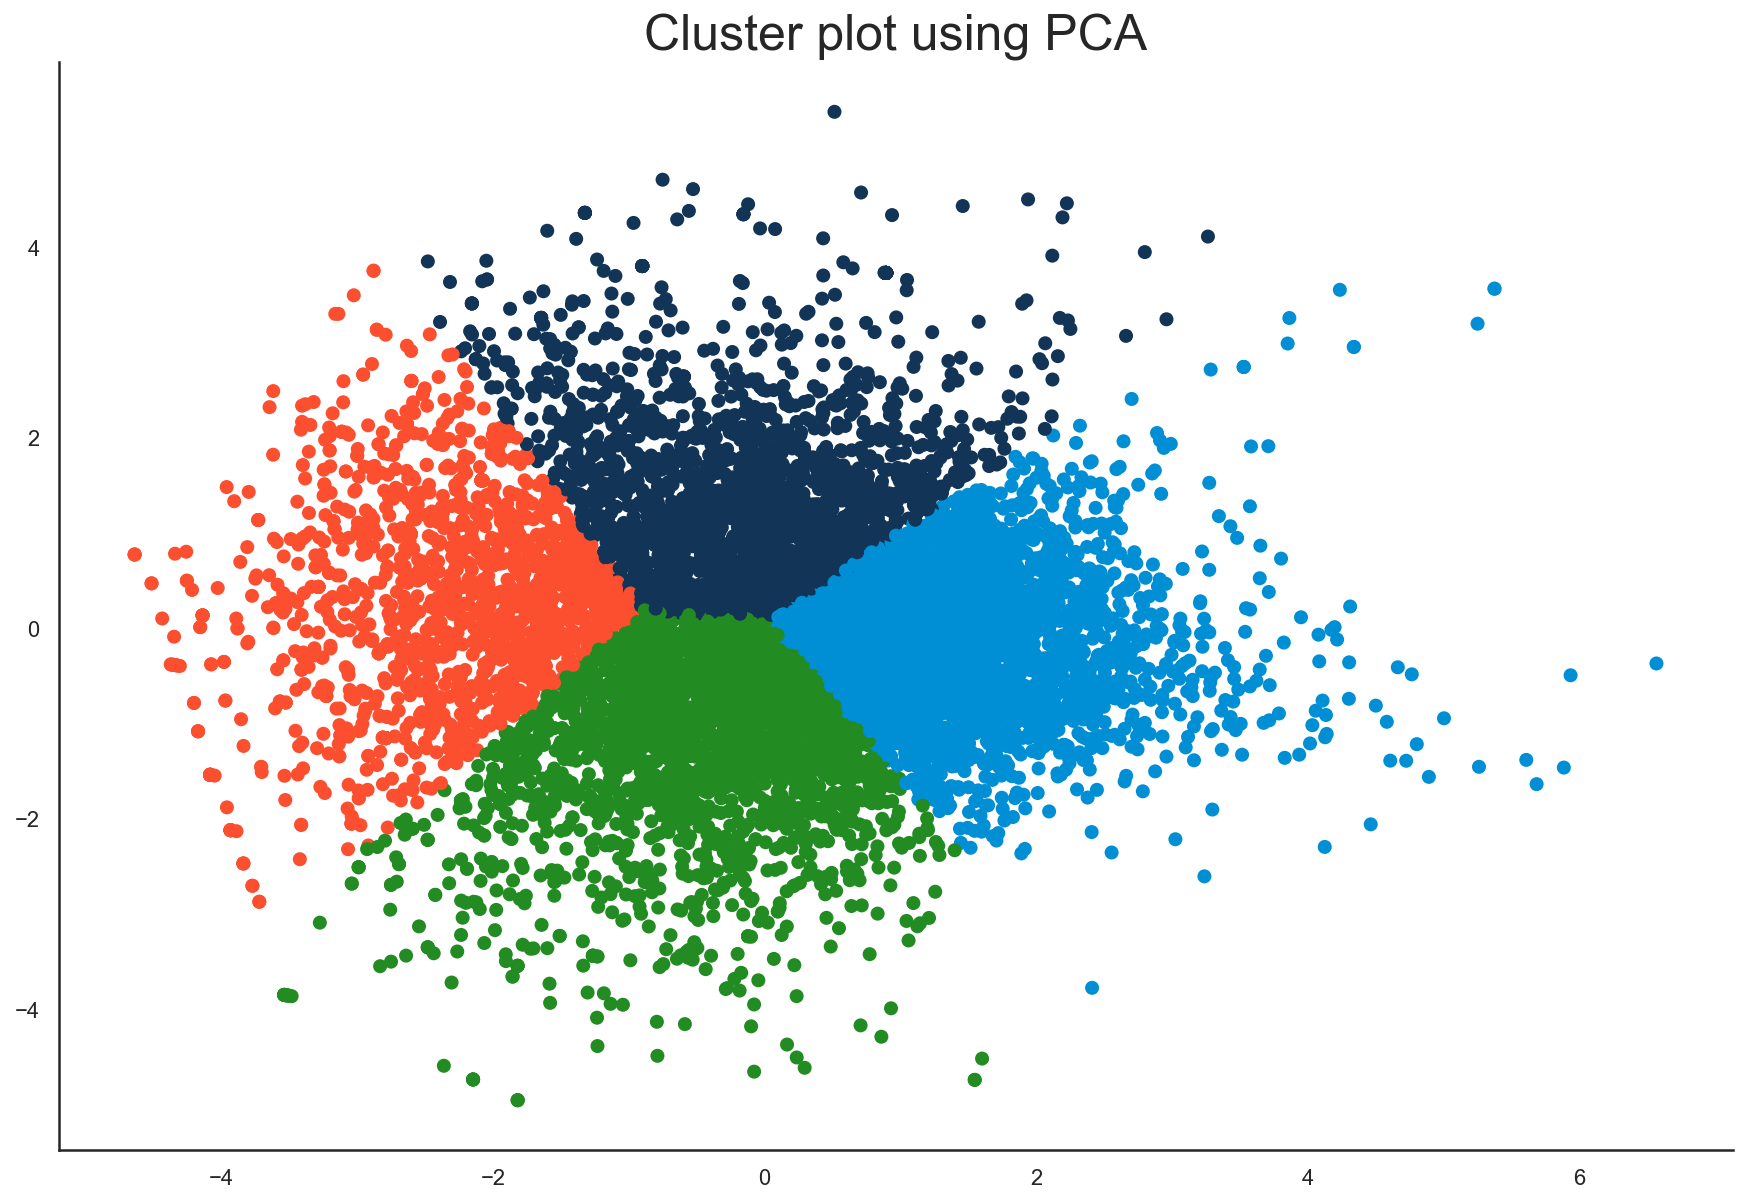

In [66]:
%matplotlib inline
#let's display the clusters on a very colorful plot

fig, ax = plt.subplots(figsize = (15,10))

fte_colors = {0.0: "#008fd5",
             1.0: "#fc4f30",
             2.0: '#123456',
             3.0: '#228B22'}

#the plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax.scatter(no_of_clusters_df[0], no_of_clusters_df[1], c = km_colors)
ax.set_title('Cluster plot using PCA', fontsize = 25)
sns.set(style = 'white')
sns.despine()


## CUSTOMER PREDICTION

Now all we need is make a text representing a possible customer prediction inputs.

In [78]:
#at the input the customer would be supposed to enter the desired city first, let's suppose it's Vienna

city = input('Please enter the city you would like to visit: \n\n ')


test_string = input('\nPlease write a sample review of a hotel, describe what you like, or tell us about yourself: \n\n')


Please enter the city you would like to visit: 

 London

Please write a sample review of a hotel, describe what you like, or tell us about yourself: 

I love hotels. Hotels are my passion. I like me some fancy receptionist that looks at me the way my  wife used to when we were twenty. Good lord the breakfast was mindblowing. I am a human reviewer. Beep, boop.


In [79]:
#now we need to vectorize it the same way we vectorized the training data
test_df = pd.DataFrame(columns=type_list)
doc = nlp(test_string)
pos = pd.DataFrame()
for token in doc:
    pos.loc[token,'pos_'] = token.pos_
    #have the pos table    
test_vector = pd.DataFrame(pos['pos_'].value_counts()).reset_index()
test_vector = test_vector.transpose()
new_header = test_vector.iloc[0]
test_vector = test_vector[1:]
test_vector.columns = new_header #there's definitely a better, faster way but whatever
test_df = pd.concat([test_df,test_vector])
test_df.fillna(0, inplace=True)            
test_df['sum'] = test_df.sum(axis=1)
test_df.loc[:,"ADJ":"X"] = test_df.loc[:,"ADJ":"X"].div(test_df["sum"], axis=0)
test_df = test_df.drop('SPACE', axis=1)

test_df

ADJ       ADP       ADV       AUX  CONJ  CCONJ       DET  INTJ  \
pos_  0.0625  0.041667  0.020833  0.083333   0.0    0.0  0.145833   0.0   

          NOUN       NUM  PART   PRON   PROPN     PUNCT  SCONJ  SYM      VERB  \
pos_  0.166667  0.020833   0.0  0.125  0.0625  0.145833    0.0  0.0  0.104167   

        X  sum  
pos_  0.0   48

In [80]:
#now we need to pass it through the same preprocessing pipeline as the training data, thus use only transform, not fit
test_df = preprocessing_pipeline.transform(test_df)

In [81]:
#now we need to predict it
predicted_cluster = kmeans.predict(test_df)
predicted_cluster

array([0])

This string's predicted cluster is 1. Let's get some nice-looking output as a final step of this notebook.

In [83]:
print('Your desired destination is {}.\n'.format(city))
print('Here is a recommendation of 5 adresses based on your writing style and reviews of other users: \n')

for i,a in enumerate(df_orig[(df_orig['City'].isin([city])) & (df_orig['CLUSTER'].isin([predicted_cluster]))]
                     .sort_values(by=['Reviewer_Score']).drop_duplicates(subset='Hotel_Address').head()['Hotel_Address']):
    print('Tip nr. {}: '.format(i+1), a)



Your desired destination is London.

Here is a recommendation of 5 adresses based on your writing style and reviews of other users: 

Tip nr. 1:  Royal Victoria Dock Western Gateway Newham London E16 1AL United Kingdom
Tip nr. 2:  Lancaster Gate Westminster Borough London W2 3LG United Kingdom
Tip nr. 3:  55 61 Westbourne Terrace Westminster Borough London W2 3UY United Kingdom
Tip nr. 4:  163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom
Tip nr. 5:  19 21 Penywern Road Kensington and Chelsea London SW5 9TT United Kingdom
